# 移动窗口函数

对与 `Series` 与 `DataFrame` 对象，大部分操作运算和矢量化方法(如`apply()`)都是在元素级别上进行运算，仍然返回长度相同的矢量数据（`n=>n`）；聚合函数则对一组数据进行操作返回一个标量值（`n=>1`）；分组聚合 `Groupby()` 与 重采样`resample()` 都是先对数据集进行分组再进行聚合操作，返回长度不同的矢量数据（`n=>m`）。

在上一节介绍的`diff()`与`pct_change()`函数是矢量化操作，返回长度相同的矢量数据，不过其计算过程需要用到相邻的两个元素。在实际工作中，类似的操作还有不少，例如计算一组数据的移动平均（Moving Average，MA），对于每个索引位置，需要用当前位置的数据以及前面多个数据来计算平均值，其结果与输入数据长度相同。，“移动平均”结果常常称为移动平均线，简称均线，可用公式表示如下：
$$F_t = \frac{A_{t} + A_{t-1} + \cdots + A_{t-n+1}}{n}$$

在进行移动平均计算时，类似于先用一个移动窗口来选择数据，然后再进行聚合操作。在 Pandas 中，这类函数也称为移动窗口函数，本节将介绍如下窗口函数：
- `rolling()`
- `expending()`
- `ewm()`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity='all'

## 滚动窗口函数 `rolling()`

`Series`与`DataFrame`对象都提供有`rolling()`方法，其使用与`groupby`操作类似先分组再聚合，区别在于使用移动窗口进行分组，其使用语法为：

```python
s.rolling(window, min_periods=None, center=False, win_type=None, on=None, axis=0, closed=None)
df.rolling(window, min_periods=None, center=False, win_type=None, on=None, axis=0, closed=None)
```
主要参数
- `windows`，移动窗口大小，整数或时间偏置字符串。
- `min_periods=None`，移动窗口最少包含的有效观测值，如果少于该数则返回缺失值。
- `center=False`，是否设定窗口中心标签索引。
- `win_type=None`，指定窗口类型，设置数据权重。
- `on=None`，对于`DataFrame`可以指定列而非使用索引。
- `closed=None`，指定数组区间开闭。
- `axis=0`，指定沿行或列聚合，确实为0。

`rolling()`运算常用聚合函数有：
- `count()`，对非 NaN 值计数
- `max()`，最大值
- `min()`，最小值
- `sum()`，求和
- `mean()`，求均值
- `median()`，求中位数
- `var()`，求方差
- `std()`，求标准差
- `skew()`，偏度（三阶矩）
- `kurt()`，峰度（四阶矩）
- `quantile()`，求中位数

例如下面创建一个`DataFrame`对象，包括两列数据且为时序数据：

In [31]:
dates = [pd.Timestamp('2018-01-01 09:00:00'),
         pd.Timestamp('2018-01-01 09:00:02'),
         pd.Timestamp('2018-01-01 09:00:03'),
         pd.Timestamp('2018-01-01 09:00:05'),
         pd.Timestamp('2018-01-01 09:00:06'),
         pd.Timestamp('2018-01-01 09:00:07'),
         pd.Timestamp('2018-01-01 09:00:08'),
         pd.Timestamp('2018-01-01 09:00:08')]
data = {'A': [0, 1, 2, 3, 4, 5, 6, 9], 'B': [0, 1, 2, np.nan, 4, 5, np.nan, 7]}
df = pd.DataFrame(data, index=dates)
df

,A,B
2018-01-01 09:00:00,0,0.0
2018-01-01 09:00:02,1,1.0
2018-01-01 09:00:03,2,2.0
2018-01-01 09:00:05,3,NaN
2018-01-01 09:00:06,4,4.0
2018-01-01 09:00:07,5,5.0
2018-01-01 09:00:08,6,NaN
2018-01-01 09:00:08,9,7.0


下面进行移动平均计算，移动窗口设置为3

In [13]:
# 移动窗口为3
df.rolling(3).mean()

,A,B
2018-01-01 09:00:00,NaN,NaN
2018-01-01 09:00:02,NaN,NaN
2018-01-01 09:00:03,1.000000,1.0
2018-01-01 09:00:05,2.000000,NaN
2018-01-01 09:00:06,3.000000,NaN
2018-01-01 09:00:07,4.000000,NaN
2018-01-01 09:00:08,5.000000,NaN
2018-01-01 09:00:08,6.666667,NaN


可以看出，移动窗口中只要有缺失值，其均值结果就是`Nan`。使用参数`min_periods=2`指定移动窗口中有两个观测值即可：

In [14]:
# 移动窗口为3
df.rolling(3, min_periods=2).mean()

,A,B
2018-01-01 09:00:00,NaN,NaN
2018-01-01 09:00:02,0.500000,0.5
2018-01-01 09:00:03,1.000000,1.0
2018-01-01 09:00:05,2.000000,1.5
2018-01-01 09:00:06,3.000000,3.0
2018-01-01 09:00:07,4.000000,4.5
2018-01-01 09:00:08,5.000000,4.5
2018-01-01 09:00:08,6.666667,6.0


对于时间序列数据，可以指定固定频率。对于时间序列数据`min_periods`缺省为1。例如下面每隔3秒进行求和：

In [21]:
# 移动窗口为3s
df.rolling('3s').sum()

,A,B
2018-01-01 09:00:00,0.0,0.0
2018-01-01 09:00:02,1.0,1.0
2018-01-01 09:00:03,3.0,3.0
2018-01-01 09:00:05,5.0,2.0
2018-01-01 09:00:06,7.0,4.0
2018-01-01 09:00:07,12.0,9.0
2018-01-01 09:00:08,15.0,9.0
2018-01-01 09:00:08,24.0,16.0


## 扩展窗口函数`expanding()`

`rolling()`函数的移动窗口是固定大小，即总是使用当前位置以及前面几个数据。扩展窗口函数`extending()`的移动窗口是从开始到当前位置，其使用语法与`rolling`类似：
 ```python
df.expanding(windows, min_periods=1, center=False, axis=0)
```

扩展窗口函数`extending()`的使用与累计求和等操作有点类似，例如下面使用`expanding()`来计算累计求和：

In [45]:
# 扩展窗口求和
df.expanding().sum()

,A,B
2018-01-01 09:00:00,0.0,0.0
2018-01-01 09:00:02,1.0,1.0
2018-01-01 09:00:03,3.0,3.0
2018-01-01 09:00:05,6.0,3.0
2018-01-01 09:00:06,10.0,7.0
2018-01-01 09:00:07,15.0,12.0
2018-01-01 09:00:08,21.0,12.0
2018-01-01 09:00:08,30.0,19.0


## 指数加权函数(`ewm()`)

Pandas 中还提供了`ewm`函数实现指数移动平均。通过指定衰减因子，指数移动平均公式可表示为：
$$F_t = \alpha A_{t} + (1-\alpha) F_{t-1}$$

指数加权函数`ewm`的使用语法为：
```python
df.ewm(com=None, span=None, halflife=None, alpha=None, min_periods=0, adjust=True, ignore_na=False, axis=0)
```
主要参数
- `com=None`, 通过质心指定衰减因子，计算公式为$\alpha=\frac{1}{\mathrm{com}+1}$
- `span=None`，通过跨度指定衰减因子，计算公式为$\alpha=\frac{2}{\mathrm{span}+1}$
- `halflife=None`，通过半衰期指定衰减因子，计算公式为$\alpha=1-\exp(\frac{\log{0.5}}{\mathrm{halflife}})$
- `alpha=None`，直接指定衰减因子
- `adjust=True`，偏差修正。

下面使用跨度`span=3`来计算指数移动平均线：

In [51]:
# 指定span=3，衰减因子0.5
df.ewm(span=3).mean()

,A,B
2018-01-01 09:00:00,0.000000,0.000000
2018-01-01 09:00:02,0.666667,0.666667
2018-01-01 09:00:03,1.428571,1.428571
2018-01-01 09:00:05,2.266667,1.428571
2018-01-01 09:00:06,3.161290,3.217391
2018-01-01 09:00:07,4.095238,4.254545
2018-01-01 09:00:08,5.055118,4.254545
2018-01-01 09:00:08,7.035294,6.174863


## 自定义聚合函数

在使用上述移动窗口函数时，除了使用已有聚合函数（如求和、求均值）外，可以使用`apply()`调用自定义聚合函数，其唯一限制是必须返回一个标量值。

例如下面定义一个计算变异系数的（最大值与最小值之差）的函数，并使用该函数进行聚合：

In [60]:
def variable_coefficient(s):
    return s.std() / s.mean()
    
df.rolling(4).apply(variable_coefficient, raw=False)

,A,B
2018-01-01 09:00:00,NaN,NaN
2018-01-01 09:00:02,NaN,NaN
2018-01-01 09:00:03,NaN,NaN
2018-01-01 09:00:05,0.860663,NaN
2018-01-01 09:00:06,0.516398,NaN
2018-01-01 09:00:07,0.368856,NaN
2018-01-01 09:00:08,0.286888,NaN
2018-01-01 09:00:08,0.360041,NaN


## 二元移动窗口函数

前面几节介绍的都是对单独一个时间序列进行移动操作，不顾类似相关度和协方差的统计计算需要操作两个时间序列。在调用`rolling()`后，可以使用如下二元聚合函数：
- `corr()`,计算相关系数
- `cov()`，计算协方差

下面创建两个带随机噪声的直线数据：

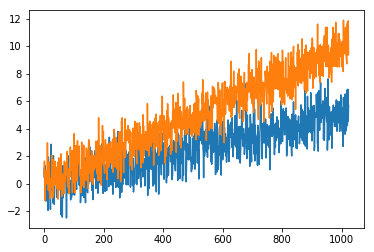

In [105]:
n = 5.0
dataa = pd.Series(np.linspace(0, n, 1024) + np.random.randn(1024))
datab = pd.Series(np.linspace(0, 2*n, 1024) + np.random.randn(1024))
plt.plot(dataa)
plt.plot(datab)

可以计算这两个数组的相关系数：

In [107]:
# 整体相关系数：
dataa.corr(datab)

0.7738361918563333

下面使用移动窗口来计算二者的相关系数：

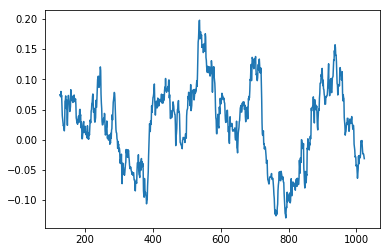

In [109]:
windows = 128
res = dataa.rolling(windows).corr(datab)
plt.plot(res)